# FASE 1.2: Voorspellen van de PV productie - vervolg

* Zonnestand in rekening brengen. 

In [1]:
import pickle
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scripts import weather_data_preprocess as wdp
from tensorflow.keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, LSTM, Dropout

## Data-analyse

In [2]:
# Ruwe weersdata info
weather_train_data_ingelmunster = [
    'Ingelmunster 2024-01-01 to 2024-01-31.csv',
    'Ingelmunster 2024-02-01 to 2024-02-29.csv',
    'Ingelmunster 2024-03-01 to 2024-03-31.csv',
    'Ingelmunster 2024-04-01 to 2024-04-30.csv',
    'Ingelmunster 2024-05-01 to 2024-05-31.csv',
    'Ingelmunster 2024-06-01 to 2024-06-30.csv',
    'Ingelmunster 2024-07-01 to 2024-07-31.csv',
    'Ingelmunster 2024-08-01 to 2024-08-31.csv',
    'Ingelmunster 2024-09-01 to 2024-09-30.csv',
    'Ingelmunster 2024-10-01 to 2024-10-31.csv',
    'Ingelmunster 2024-11-01 to 2024-11-30.csv',
    'Ingelmunster 2024-12-01 to 2024-12-31.csv'
]
weather_train_data_gullegem = [
    'Gullegem 2024-01-01 to 2024-01-31.csv',
    'Gullegem 2024-02-01 to 2024-02-29.csv',
    'Gullegem 2024-03-01 to 2024-03-31.csv',
    'Gullegem 2024-04-01 to 2024-04-30.csv',
    'Gullegem 2024-05-01 to 2024-05-31.csv',
    'Gullegem 2024-06-01 to 2024-06-30.csv',
    'Gullegem 2024-07-01 to 2024-07-31.csv',
    'Gullegem 2024-08-01 to 2024-08-31.csv',
    'Gullegem 2024-09-01 to 2024-09-30.csv',
    'Gullegem 2024-10-01 to 2024-10-31.csv',
    'Gullegem 2024-11-01 to 2024-11-30.csv',
    'Gullegem 2024-12-01 to 2024-12-31.csv'
]
weather_test_data_ingelmunster = [
    'Ingelmunster 2025-01-01 to 2025-01-31.csv',
]
weather_test_data_gullegem = [
    'Ingelmunster 2025-01-01 to 2025-01-31.csv',
]
ingelmunster_location = [50.920699369528734, 3.2532075343447575]
gullegem_location = [50.8447689, 3.1989718]

In [3]:
# importeren van de ruwe weersdata en deze preprocessen
processor = wdp.WeatherDataPreprocess()
df_weather_ingelmunster = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
df_weather_gullegem = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
df_weather_test_ingelmunster = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
df_weather_test_gullegem = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
for file in range(len(weather_train_data_ingelmunster)):
    print(f'Processing {weather_train_data_ingelmunster[file]}')
    df_weather_ingelmunster = pd.concat([df_weather_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_train_data_ingelmunster[file])])
for file in range(len(weather_test_data_ingelmunster)):
    print(f'Processing {weather_test_data_ingelmunster[file]}')
    df_weather_test_ingelmunster = pd.concat([df_weather_test_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_test_data_ingelmunster[file])])
for file in range(len(weather_train_data_gullegem)):
    print(f'Processing {weather_train_data_gullegem[file]}')
    df_weather_gullegem = pd.concat([df_weather_gullegem, processor.preprocessWeatherData(lat=gullegem_location[0], lng=gullegem_location[1], file_name=weather_train_data_gullegem[file])])
for file in range(len(weather_test_data_gullegem)):
    print(f'Processing {weather_test_data_gullegem[file]}')
    df_weather_test_gullegem = pd.concat([df_weather_test_gullegem, processor.preprocessWeatherData(lat=gullegem_location[0], lng=gullegem_location[1], file_name=weather_test_data_gullegem[file])])
df_weather_ingelmunster.head(10)

Processing Ingelmunster 2024-01-01 to 2024-01-31.csv
Processing Ingelmunster 2024-02-01 to 2024-02-29.csv
Processing Ingelmunster 2024-03-01 to 2024-03-31.csv
Processing Ingelmunster 2024-04-01 to 2024-04-30.csv
Processing Ingelmunster 2024-05-01 to 2024-05-31.csv
Processing Ingelmunster 2024-06-01 to 2024-06-30.csv
Processing Ingelmunster 2024-07-01 to 2024-07-31.csv
Processing Ingelmunster 2024-08-01 to 2024-08-31.csv
Processing Ingelmunster 2024-09-01 to 2024-09-30.csv
Processing Ingelmunster 2024-10-01 to 2024-10-31.csv
Processing Ingelmunster 2024-11-01 to 2024-11-30.csv
Processing Ingelmunster 2024-12-01 to 2024-12-31.csv
Processing Ingelmunster 2025-01-01 to 2025-01-31.csv
Processing Gullegem 2024-01-01 to 2024-01-31.csv
Processing Gullegem 2024-02-01 to 2024-02-29.csv
Processing Gullegem 2024-03-01 to 2024-03-31.csv
Processing Gullegem 2024-04-01 to 2024-04-30.csv
Processing Gullegem 2024-05-01 to 2024-05-31.csv
Processing Gullegem 2024-06-01 to 2024-06-30.csv
Processing Gulleg

,datetime,temp,humidity,cloudcover,solarenergy,uvindex,latitude,longitude,solar_azimuth,solar_elevation
0,2024-01-01 00:00:00,7.200,89.080,96.300,0.0,0.0,50.920699,3.253208,-3.058781,-1.083954
1,2024-01-01 00:15:00,7.125,89.600,96.600,0.0,0.0,50.920699,3.253208,-2.931440,-1.077916
2,2024-01-01 00:30:00,7.050,90.120,96.900,0.0,0.0,50.920699,3.253208,-2.807635,-1.066812
3,2024-01-01 00:45:00,6.975,90.640,97.200,0.0,0.0,50.920699,3.253208,-2.689024,-1.050984
4,2024-01-01 01:00:00,6.900,91.160,97.500,0.0,0.0,50.920699,3.253208,-2.576724,-1.030873
5,2024-01-01 01:15:00,7.000,91.195,95.725,0.0,0.0,50.920699,3.253208,-2.471311,-1.006968
6,2024-01-01 01:30:00,7.100,91.230,93.950,0.0,0.0,50.920699,3.253208,-2.372902,-0.979768
7,2024-01-01 01:45:00,7.200,91.265,92.175,0.0,0.0,50.920699,3.253208,-2.281271,-0.949750
8,2024-01-01 02:00:00,7.300,91.300,90.400,0.0,0.0,50.920699,3.253208,-2.195979,-0.917351
9,2024-01-01 02:15:00,7.325,90.540,90.800,0.0,0.0,50.920699,3.253208,-2.116463,-0.882961


In [4]:
# Een checkpoint toevoegen voor de ruwe weersdata
df_weather_ingelmunster.to_csv('data/processed/ingelmunster_weather_data.csv', index=False)
df_weather_gullegem.to_csv('data/processed/gullegem_weather_data.csv', index=False)

In [5]:
# Verwijderen van de kolommen die niet nodig zijn
df_weather_ingelmunster.drop(columns=['humidity', 'latitude', 'longitude'], inplace=True)
df_weather_test_ingelmunster.drop(columns=['humidity', 'latitude', 'longitude'], inplace=True)
df_weather_gullegem.drop(columns=['humidity', 'latitude', 'longitude'], inplace=True)
df_weather_test_gullegem.drop(columns=['humidity', 'latitude', 'longitude'], inplace=True)

In [6]:
# Importeren van de ruwe productiedata en deze preprocessen
df_all_jvr = pd.read_csv('data/processed/pv_jvr_total.csv')
df_all_jvr['datetime'] = pd.to_datetime(df_all_jvr['datetime'])
df_all_ddp = pd.read_csv('data/processed/pv_ddp_total.csv')
df_all_ddp['datetime'] = pd.to_datetime(df_all_ddp['datetime'])
# Filter data voor een train en test set
df_production_jvr = df_all_jvr[df_all_jvr['datetime'].dt.year == 2024]
df_production_test_jvr = df_all_jvr[df_all_jvr['datetime'].dt.year == 2025]
df_production_ddp = df_all_ddp[df_all_ddp['datetime'].dt.year == 2024]
df_production_test_ddp = df_all_ddp[df_all_ddp['datetime'].dt.year == 2025]
df_production_jvr.tail(10)

,datetime,total_production_kwh,production_15_min_kwh,production_15_min_%
26943,2024-12-31 21:30:00,20591.94,0.0,0.0
26944,2024-12-31 21:45:00,20591.94,0.0,0.0
26945,2024-12-31 22:00:00,20591.94,0.0,0.0
26946,2024-12-31 22:15:00,20591.94,0.0,0.0
26947,2024-12-31 22:30:00,20591.94,0.0,0.0
26948,2024-12-31 22:45:00,20591.94,0.0,0.0
26949,2024-12-31 23:00:00,20591.94,0.0,0.0
26950,2024-12-31 23:15:00,20591.94,0.0,0.0
26951,2024-12-31 23:30:00,20591.94,0.0,0.0
26952,2024-12-31 23:45:00,20591.94,0.0,0.0


In [7]:
# Voeg de twee dataframes samen
df_jvr = pd.merge(df_production_jvr, df_weather_ingelmunster, on='datetime')
df_jvr.drop(columns=['total_production_kwh', 'production_15_min_kwh'], inplace=True)
df_ddp = pd.merge(df_production_ddp, df_weather_gullegem, on='datetime')
df_ddp.drop(columns=['total_production_kwh', 'production_15_min_kwh'], inplace=True)
df_test_jvr = pd.merge(df_production_test_jvr, df_weather_test_ingelmunster, on='datetime')
df_test_jvr.drop(columns=['total_production_kwh', 'production_15_min_kwh'], inplace=True)
df_test_ddp = pd.merge(df_production_test_ddp, df_weather_test_gullegem, on='datetime')
df_test_ddp.drop(columns=['total_production_kwh', 'production_15_min_kwh'], inplace=True)
df_jvr.head(10)

,datetime,production_15_min_%,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation
0,2024-03-14 08:15:00,0.092,8.325,54.475,0.325,0.5,-1.054120,0.330412
1,2024-03-14 08:45:00,0.387,9.175,46.225,0.575,1.5,-0.935324,0.399732
2,2024-03-14 09:00:00,0.231,9.600,42.100,0.700,2.0,-0.873267,0.432229
3,2024-03-14 09:15:00,0.203,10.000,48.875,0.900,2.5,-0.809274,0.463056
4,2024-03-14 09:30:00,0.172,10.400,55.650,1.100,3.0,-0.743247,0.492032
5,2024-03-14 09:45:00,0.085,10.800,62.425,1.300,3.5,-0.675122,0.518972
6,2024-03-14 12:00:00,4.431,14.800,52.400,2.000,6.0,0.018610,0.640320
7,2024-03-14 12:15:00,0.826,14.925,50.300,1.850,5.5,0.100055,0.637944
8,2024-03-14 12:30:00,0.747,15.050,48.200,1.700,5.0,0.181001,0.632235
9,2024-03-14 12:45:00,0.404,15.175,46.100,1.550,4.5,0.261057,0.623258


In [8]:
# De trainingsdata van beide huizen samenvoegen
df_jvr_lstm = df_jvr.copy()
df_ddp_lstm = df_ddp.copy()

In [9]:
# Geef de dag van het jaar weer als een sinus- en cosinusgolf
# Dag van het jaar extraheren
df_jvr_lstm['day_of_year'] = df_jvr_lstm['datetime'].dt.dayofyear
df_ddp_lstm['day_of_year'] = df_ddp_lstm['datetime'].dt.dayofyear
df_test_jvr['day_of_year'] = df_test_jvr['datetime'].dt.dayofyear
df_test_ddp['day_of_year'] = df_test_ddp['datetime'].dt.dayofyear
# Bereken sinus- en cosinuswaarden voor day_of_year
df_jvr_lstm['day_of_year_sine'] = np.sin(2 * np.pi * df_jvr_lstm['day_of_year'] / 365)
df_jvr_lstm['day_of_year_cosine'] = np.cos(2 * np.pi * df_jvr_lstm['day_of_year'] / 365)
df_ddp_lstm['day_of_year_sine'] = np.sin(2 * np.pi * df_ddp_lstm['day_of_year'] / 365)
df_ddp_lstm['day_of_year_cosine'] = np.cos(2 * np.pi * df_ddp_lstm['day_of_year'] / 365)
df_test_jvr['day_of_year_sine'] = np.sin(2 * np.pi * df_test_jvr['day_of_year'] / 365)
df_test_jvr['day_of_year_cosine'] = np.cos(2 * np.pi * df_test_jvr['day_of_year'] / 365)
df_test_ddp['day_of_year_sine'] = np.sin(2 * np.pi * df_test_ddp['day_of_year'] / 365)
df_test_ddp['day_of_year_cosine'] = np.cos(2 * np.pi * df_test_ddp['day_of_year'] / 365)

In [10]:
# Verwijder onnodige kolommen
df_jvr_lstm.drop(columns=['datetime', 'day_of_year'], inplace=True)
df_ddp_lstm.drop(columns=['datetime', 'day_of_year'], inplace=True)
df_test_jvr.drop(columns=['datetime', 'day_of_year'], inplace=True)
df_test_ddp.drop(columns=['datetime', 'day_of_year'], inplace=True)

In [11]:
# Vervang alle negatieve energiewaarden (%) met 0
df_jvr_lstm['production_15_min_%'] = df_jvr_lstm['production_15_min_%'].apply(lambda x: x if x >= 0 else 0)
df_ddp_lstm['production_15_min_%'] = df_ddp_lstm['production_15_min_%'].apply(lambda x: x if x >= 0 else 0)
df_test_jvr['production_15_min_%'] = df_test_jvr['production_15_min_%'].apply(lambda x: x if x >= 0 else 0)
df_test_ddp['production_15_min_%'] = df_test_ddp['production_15_min_%'].apply(lambda x: x if x >= 0 else 0)

In [12]:
# maak het percentage energie een een waarde tussen 0 en 100%
df_jvr_lstm['production_15_min_%'] = df_jvr_lstm['production_15_min_%'] * 100
df_ddp_lstm['production_15_min_%'] = df_ddp_lstm['production_15_min_%'] * 100
df_test_jvr['production_15_min_%'] = df_test_jvr['production_15_min_%'] * 100
df_test_ddp['production_15_min_%'] = df_test_ddp['production_15_min_%'] * 100

In [13]:
# Estetic action move target column to the end
df_jvr_lstm = pd.concat([df_jvr_lstm.drop('production_15_min_%', axis=1), df_jvr_lstm['production_15_min_%']], axis=1)
df_ddp_lstm = pd.concat([df_ddp_lstm.drop('production_15_min_%', axis=1), df_ddp_lstm['production_15_min_%']], axis=1)

In [14]:
# Alle waarden boven de 100(%) zijn uitschieters (dit zijn waarschijnlijk fouten als gevolg van ontbrekende gegevens). Deze worden verwijderd.
df_jvr_lstm = df_jvr_lstm[df_jvr_lstm['production_15_min_%'] <= 100]
df_ddp_lstm = df_ddp_lstm[df_ddp_lstm['production_15_min_%'] <= 100]

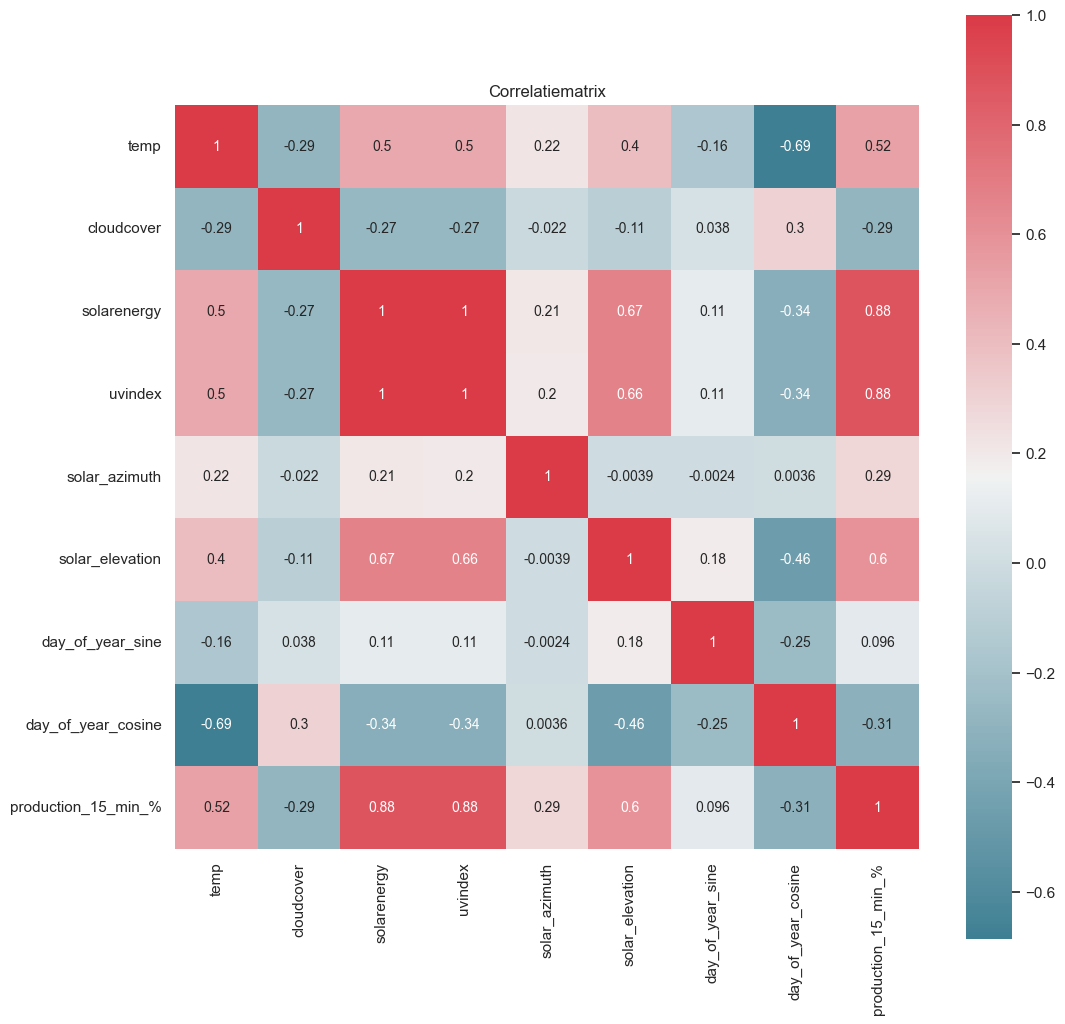

In [15]:
# Lineaire correlatie tussen de features - heatmap
# Visualiseer de onderlinge correlatiecoëfficiënten
f, ax = plt.subplots(figsize=(12, 12))
corr = df_jvr_lstm.corr()
sns.heatmap(
    corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    square=True,
    ax=ax,
    annot=True,
    annot_kws={"size": 10}
)
plt.title("Correlatiematrix")
plt.show()

## Pre-processing van de data

In [16]:
datasets = [df_jvr_lstm, df_ddp_lstm, df_test_jvr, df_test_ddp]

def create_sequences(data, target, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i+n_steps_in])
        y.append(target[i+n_steps_in+n_steps_out-1 : i+n_steps_in+n_steps_out])
    return np.array(X), np.array(y)

df_jvr_lstm_target = df_jvr_lstm['production_15_min_%'].values
df_ddp_lstm_target = df_ddp_lstm['production_15_min_%'].values
df_test_jvr_target = df_test_jvr['production_15_min_%'].values
df_test_ddp_target = df_test_ddp['production_15_min_%'].values
df_jvr_lstm_values = df_jvr_lstm.copy()
df_ddp_lstm_values = df_ddp_lstm.copy()
df_test_jvr_lstm_values = df_test_jvr.copy()
df_test_ddp_lstm_values = df_test_ddp.copy()
# df_jvr_lstm_values.drop(columns=['production_15_min_%'], inplace=True)
# df_ddp_lstm_values.drop(columns=['production_15_min_%'], inplace=True)
# df_test_jvr_lstm_values.drop(columns=['production_15_min_%'], inplace=True)
# df_test_ddp_lstm_values.drop(columns=['production_15_min_%'], inplace=True)
# Reshape de dataframes naar een 3D-array for a predictie van 24 uur
X_jvr_24_hours, y_jvr_24_hours = create_sequences(df_jvr_lstm_values.values, df_jvr_lstm_target, 96, 96)
X_ddp_24_hours, y_ddp_24_hours = create_sequences(df_ddp_lstm_values.values, df_ddp_lstm_target, 96, 96)
X_test_jvr_24_hours, y_test_jvr_24_hours = create_sequences(df_test_jvr_lstm_values.values, df_test_jvr_target, 96, 96)
X_test_ddp_24_hours, y_test_ddp_24_hours = create_sequences(df_test_ddp_lstm_values.values, df_test_ddp_target, 96, 96)

In [17]:
# Samenvoegen van de datasets
X_24_hours = np.concatenate((X_jvr_24_hours, X_ddp_24_hours), axis=0)
y_24_hours = np.concatenate((y_jvr_24_hours, y_ddp_24_hours), axis=0)

lstm_24_Scaler = MinMaxScaler()
X_24_hours = lstm_24_Scaler.fit_transform(X_24_hours.reshape(-1, X_24_hours.shape[-1])).reshape(X_24_hours.shape)

## Training

In [18]:
LSTM_network_model_24_hour = Sequential()

LSTM_network_model_24_hour.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(96, 9)))
LSTM_network_model_24_hour.add(Dropout(0.2))
LSTM_network_model_24_hour.add(LSTM(64, activation='tanh'))
LSTM_network_model_24_hour.add(Dense(32, activation='relu'))
LSTM_network_model_24_hour.add(Dense(1, activation='linear'))
LSTM_network_model_24_hour.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
LSTM_network_model_24_hour.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 96, 128)           70656     
                                                                 
 dropout (Dropout)           (None, 96, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 122177 (477.25 KB)
Trainable params: 122177 (477.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
checkpoint_name_24_hour = 'pv_lstm_24_hours.keras' 
checkpoint_24_hour = ModelCheckpoint(f'models/{checkpoint_name_24_hour}', monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list_24_hour = [checkpoint_24_hour]

In [20]:
history_24_hours = LSTM_network_model_24_hour.fit(X_24_hours, y_24_hours, epochs=20, batch_size=400, validation_split = 0.2, callbacks=callbacks_list_24_hour)

Epoch 1/20
107/107 [==============================] - ETA: 0s - loss: 595.5859 - mean_squared_error: 595.5859
Epoch 1: val_loss improved from inf to 235.18523, saving model to models/pv_lstm_24_hours.keras
107/107 [==============================] - 47s 434ms/step - loss: 595.5859 - mean_squared_error: 595.5859 - val_loss: 235.1852 - val_mean_squared_error: 235.1852
Epoch 2/20
107/107 [==============================] - ETA: 0s - loss: 556.6068 - mean_squared_error: 556.6068
Epoch 2: val_loss improved from 235.18523 to 233.27467, saving model to models/pv_lstm_24_hours.keras
107/107 [==============================] - 48s 452ms/step - loss: 556.6068 - mean_squared_error: 556.6068 - val_loss: 233.2747 - val_mean_squared_error: 233.2747
Epoch 3/20
107/107 [==============================] - ETA: 0s - loss: 437.7852 - mean_squared_error: 437.7852
Epoch 3: val_loss improved from 233.27467 to 68.95415, saving model to models/pv_lstm_24_hours.keras
107/107 [==============================] - 52s 

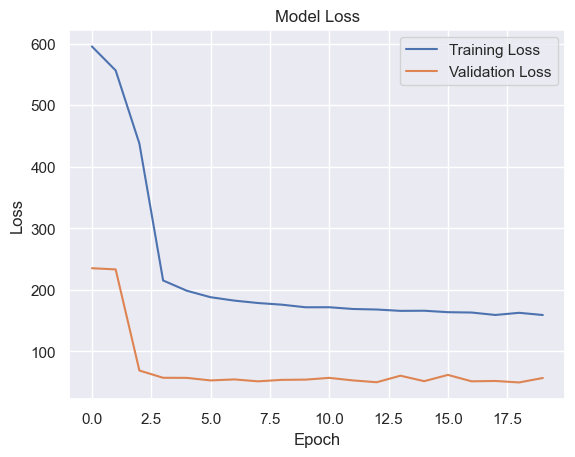

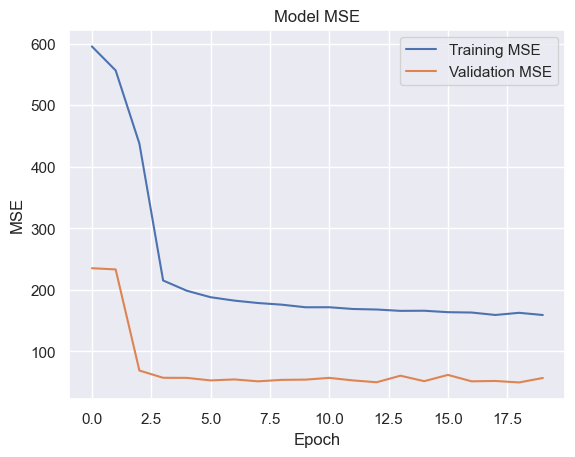

In [21]:
# Plot training and validation loss
plt.plot(history_24_hours.history['loss'], label='Training Loss')
plt.plot(history_24_hours.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(history_24_hours.history['mean_squared_error'], label='Training MSE')
plt.plot(history_24_hours.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Testing

In [22]:
df_test_jvr.head()

,production_15_min_%,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,day_of_year_sine,day_of_year_cosine
0,0.0,8.1,96.300,0.0,0.0,-3.061625,-1.083037,0.017213,0.999852
1,0.0,8.1,95.225,0.0,0.0,-2.934409,-1.077116,0.017213,0.999852
2,0.0,8.1,94.150,0.0,0.0,-2.810672,-1.066131,0.017213,0.999852
3,0.0,8.1,93.075,0.0,0.0,-2.692074,-1.050418,0.017213,0.999852
4,0.0,8.1,92.000,0.0,0.0,-2.579743,-1.030415,0.017213,0.999852


In [23]:
# Splits de dataset in een trainings- en testset
actual_lstm_24_hours = y_test_jvr_24_hours
input_lstm_24_hours = X_test_jvr_24_hours

In [24]:
# Inladen van het beste LSTM model op 24h
best_lstm_model_24_hour = load_model('models/pv_lstm_24_hours.keras')

In [25]:
# Maak een voorspelling voor elke regel in de testdataset
input_lstm_24_hours = lstm_24_Scaler.transform(input_lstm_24_hours.reshape(-1, input_lstm_24_hours.shape[-1])).reshape(input_lstm_24_hours.shape)
df_result_lstm_24_hour = pd.DataFrame(actual_lstm_24_hours, columns=['production_15_min_%'])

In [26]:
df_result_lstm_24_hour['predicted_with_LSTM_24_hour(%)'] = best_lstm_model_24_hour.predict(input_lstm_24_hours)
df_result_lstm_24_hour['predicted_with_LSTM_24_hour(%)'] = df_result_lstm_24_hour['predicted_with_LSTM_24_hour(%)'].apply(lambda x: x if x >= 0 else 0)
df_result_lstm_24_hour.head()

87/87 [==============================] - 3s 28ms/step


,production_15_min_%,predicted_with_LSTM_24_hour(%)
0,0.0,6.228431
1,0.0,6.128118
2,0.0,6.073025
3,0.0,6.042894
4,0.0,6.031775


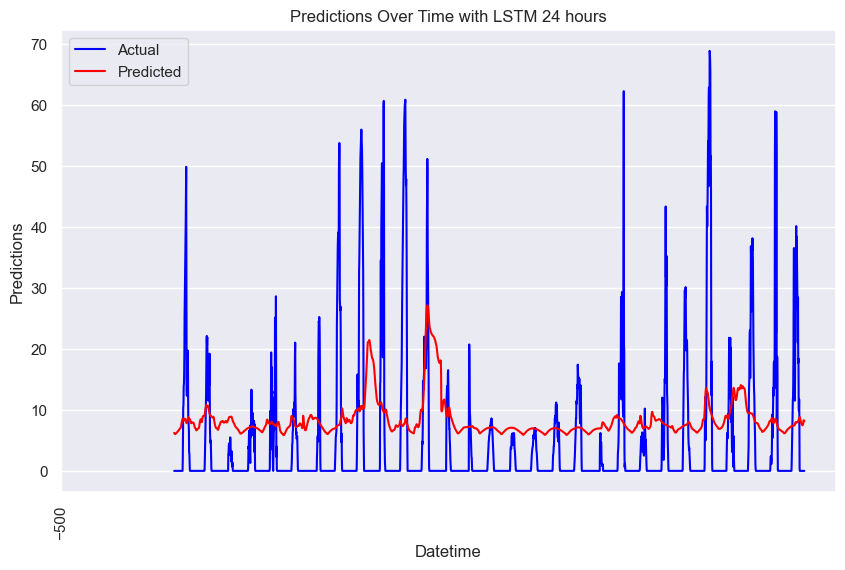

In [27]:
# Zet de voorspellingen uit in een grafiek LSTM 24h
plt.figure(figsize=(10, 6))
plt.plot(df_result_lstm_24_hour['production_15_min_%'], label='Actual', color='blue')
plt.plot(df_result_lstm_24_hour['predicted_with_LSTM_24_hour(%)'], label='Predicted', color='red')
plt.xlabel('Datetime')
plt.ylabel('Predictions')
plt.title('Predictions Over Time with LSTM 24 hours')
plt.grid(True)
x_ticks = plt.gca().get_xticks()
x_ticks_selected = x_ticks[::24]
plt.xticks(x_ticks_selected, rotation=90)
plt.legend()
plt.show()

In [28]:
# Calculating the accuracy of each model based on the test data
print("### LSTM-model 24 hours ###")
print(f"mae: {mean_absolute_error(df_result_lstm_24_hour['production_15_min_%'], df_result_lstm_24_hour['predicted_with_LSTM_24_hour(%)'])}")
print(f"mse: {mean_squared_error(df_result_lstm_24_hour['production_15_min_%'], df_result_lstm_24_hour['predicted_with_LSTM_24_hour(%)'])}")
print(f"r2: {r2_score(df_result_lstm_24_hour['production_15_min_%'], df_result_lstm_24_hour['predicted_with_LSTM_24_hour(%)'])}")

### LSTM-model 24 hours ###
mae: 8.622905898008476
mse: 125.38233379325433
r2: -0.1203029082932825
